# CTEFNet: 基于 CNN 与迁移学习的厄尔尼诺预测模型

## 技术路径

MindSpore Earth求解该问题的具体流程如下:

1. 创建数据集
2. 模型构建
3. 损失函数
4. 模型训练
5. 模型评估与可视化

## 1. 下载并构建数据集

训练和测试所用的数据集可以在: [mindearth/dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/enso_dataset.zip) 下载。

## 2. 安装并导入依赖库


In [1]:
import os
import random

import numpy as np

from mindspore import set_seed
from mindspore import context
import mindspore.dataset as ds
from mindspore.train.serialization import load_param_into_net

In [3]:
from mindearth.module import Trainer
from mindearth.utils import load_yaml_config, create_logger
from src import WeightedLoss, CTEFNet, InferenceModule, EvaluateCallBack
from src import ReanalysisData, plot_correlation, get_param_dict, init_dataloader

In [4]:
set_seed(0)
np.random.seed(0)
random.seed(0)

模型涉及的参数、优化器、数据配置见[config](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforecast/configs/pretrain.yaml)。

In [5]:
config = load_yaml_config("./configs/pretrain.yaml")
context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU", device_id=0)

## 3. 模型构建

模型初始化：

In [6]:
config['data']['obs_time'] = 12 # 观测时长
config['data']['pred_time'] = 23 # 预测时长
logger = create_logger(os.path.join(os.path.abspath(config['summary']["summary_dir"]), "results.log"))

In [7]:
data_params = config.get("data")
model_params = config.get("model")
model = CTEFNet(
        cov_hidden_channels=model_params.get('cov_hidden_channels'),
        cov_out_channels=model_params.get('cov_out_channels'),
        heads=model_params.get('heads'),
        num_layer=model_params.get('num_layer'),
        feedforward_dims=model_params.get('feedforward_dims'),
        dropout=model_params.get('dropout'),
        obs_time=data_params.get('obs_time'),
        pred_time=data_params.get('pred_time')
    )

## 4. 设计损失函数

CTEFNet 在模型训练中使用自定义加权损失。计算公式见README.md。

In [8]:
opt_params = config.get("optimizer")
loss_fn = WeightedLoss(
    lambda_1=opt_params.get('loss_alpha'),
    lambda_2=opt_params.get('loss_beta'),
    lambda_3=opt_params.get('loss_gamma'),
    obs_time=data_params.get('obs_time')
)

## 5. 模型训练

通过继承`Trainer`并重写`get_dataset`成员函数来加入自定义数据，并重写了`get_callback`成员函数来在训练过程中对测试数据集执行推理。模型训练可以分为预训练和调优两步。

MindSpore Earth提供训练和推理接口，使用2.0.0及之后的MindSpore训练网络。

In [9]:
class CTEFTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super().__init__(config, model, loss_fn, logger)
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.pred_cb = self.get_callback()

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb


    def get_dataset(self):
        train_dataloader, valid_dataloader = init_dataloader(self.config)
        return train_dataloader, valid_dataloader

### 5.1 预训练

首先使用 CMIP5 数据进行预训练。

In [10]:
config['data']["train_dataset"] = "CMIP5" # 训练数据集
config['data']["train_period"] = [1861, 2004] # 训练周期
config['data']["valid_dataset"] = "Reanalysis" # 评估数据集
config['data']["valid_period"] = [1941, 1983] # 评估周期
config['data']["t_in"] = 1  # 训练阶段
config['data']["t_out_train"] = 1  # 训练阶段
config['optimizer']['name'] = 'adam'  # 优化器
config['optimizer']['initial_lr'] = 0.0008  # 学习率
config['optimizer']['epochs'] = 3  # 训练批次

trainer = CTEFTrainer(config, model, loss_fn, logger)
trainer.train()

2024-06-12 16:11:34,142 - pretrain.py[line:215] - INFO: steps_per_epoch: 60
[WARNING] KERNEL(4245,7f6cea09e700,python):2024-06-12-16:11:37.023.186 [mindspore/ccsrc/plugin/device/gpu/kernel/gpu_kernel.cc:40] CheckDeviceSm] It is recommended to use devices with a computing capacity >= 7, but the current device's computing capacity is 6


epoch: 1 step: 1, loss is 1.3907255
epoch: 1 step: 2, loss is 1.4420426
epoch: 1 step: 3, loss is 1.4253227
epoch: 1 step: 4, loss is 1.4261664
epoch: 1 step: 5, loss is 1.4435985
epoch: 1 step: 6, loss is 1.4107667
epoch: 1 step: 7, loss is 1.3576393
epoch: 1 step: 8, loss is 1.4618604
epoch: 1 step: 9, loss is 1.3308278
epoch: 1 step: 10, loss is 1.2488767
epoch: 1 step: 11, loss is 1.2698145
epoch: 1 step: 12, loss is 1.1726741
epoch: 1 step: 13, loss is 1.3041803
epoch: 1 step: 14, loss is 1.3114269
epoch: 1 step: 15, loss is 1.3172023
epoch: 1 step: 16, loss is 1.287687
epoch: 1 step: 17, loss is 1.25256
epoch: 1 step: 18, loss is 1.2240134
epoch: 1 step: 19, loss is 1.1878266
epoch: 1 step: 20, loss is 1.182579
epoch: 1 step: 21, loss is 1.1606466
epoch: 1 step: 22, loss is 1.1976378
epoch: 1 step: 23, loss is 1.1302509
epoch: 1 step: 24, loss is 1.0484028
epoch: 1 step: 25, loss is 0.93567854
epoch: 1 step: 26, loss is 0.92280746
epoch: 1 step: 27, loss is 1.0322134
epoch: 1 ste

### 5.2 模型调优

使用1984年前的 SODA 再分析数据对模型进行调优

In [12]:
config['data']["train_dataset"] = "Reanalysis" # 训练数据集
config['data']["train_period"] = [1941, 1983] # 训练周期
config['data']["valid_dataset"] = "Reanalysis" # 评估数据集
config['data']["valid_period"] = [1984, 2008] # 评估周期
config['data']["t_in"] = 2  # 训练阶段
config['data']["t_out_train"] = 1  # 训练阶段
config['optimizer']['name'] = 'sgd'  # 优化器
config['optimizer']['finetune_lr'] = 0.001  # 调优学习率
config['optimizer']['epochs'] = 100  # 训练批次

trainer = CTEFTrainer(config, model, loss_fn, logger)
trainer.train()

2024-06-12 16:20:57,077 - pretrain.py[line:215] - INFO: steps_per_epoch: 1


epoch: 1 step: 1, loss is 0.5750885
Train epoch time: 3053.514 ms, per step time: 3053.514 ms
epoch: 2 step: 1, loss is 0.54179406
Train epoch time: 742.249 ms, per step time: 742.249 ms
epoch: 3 step: 1, loss is 0.53568
Train epoch time: 809.872 ms, per step time: 809.872 ms
epoch: 4 step: 1, loss is 0.52220225
Train epoch time: 874.464 ms, per step time: 874.464 ms
epoch: 5 step: 1, loss is 0.5211032
Train epoch time: 1282.578 ms, per step time: 1282.578 ms
epoch: 6 step: 1, loss is 0.51847315
Train epoch time: 635.916 ms, per step time: 635.916 ms
epoch: 7 step: 1, loss is 0.5152263
Train epoch time: 608.059 ms, per step time: 608.059 ms
epoch: 8 step: 1, loss is 0.5152715
Train epoch time: 587.414 ms, per step time: 587.414 ms
epoch: 9 step: 1, loss is 0.511709
Train epoch time: 619.830 ms, per step time: 619.830 ms
epoch: 10 step: 1, loss is 0.50936556
Train epoch time: 1042.933 ms, per step time: 1042.933 ms
epoch: 11 step: 1, loss is 0.5031694
Train epoch time: 655.465 ms, per s

## 6. 模型评估和可视化

完成训练后，我们使用ckpt进行推理。下述展示了nino3.4指数预测值、真实值的相关系数。

In [15]:
test_dataset = ReanalysisData(
    data_params.get('root_dir'),
    data_params.get('test_period'),
    data_params.get('obs_time'),
    data_params.get('pred_time')
)
test_dataloader = ds.GeneratorDataset(
    test_dataset,
    ["data", "index"],
    shuffle=False).batch(data_params.get('valid_batch_size'), False)

In [16]:
corr_list = []
for t in range(1, 2+1):
    param_dict, file_dir = get_param_dict(config, t)
    load_param_into_net(model, param_dict)
    logger.info(f"Load pre-trained model successfully, {file_dir}")
    inference_module = InferenceModule(model, config, logger)
    corr_list.append(inference_module.eval(test_dataloader)[data_params.get('obs_time'):])

2024-06-12 16:26:04,031 - 2085024365.py[line:5] - INFO: Load pre-trained model successfully, ./summary/ckpt/step_1


OBS Accuracy: 97.14%, Pred Accuracy: 62.84%, Pred Corr:
[0.96 0.92 0.87 0.82 0.78 0.74 0.72 0.71 0.71 0.71 0.7  0.69 0.66 0.65
 0.61 0.58 0.53 0.47 0.43 0.35 0.3  0.31 0.25]


2024-06-12 16:26:04,748 - 2085024365.py[line:5] - INFO: Load pre-trained model successfully, ./summary/ckpt/step_2


OBS Accuracy: 97.11%, Pred Accuracy: 63.81%, Pred Corr:
[0.96 0.92 0.88 0.83 0.8  0.76 0.74 0.72 0.72 0.73 0.72 0.71 0.68 0.66
 0.61 0.59 0.52 0.48 0.43 0.36 0.31 0.31 0.25]


最后生成可视化预训练与调优结果可视化图表如下。

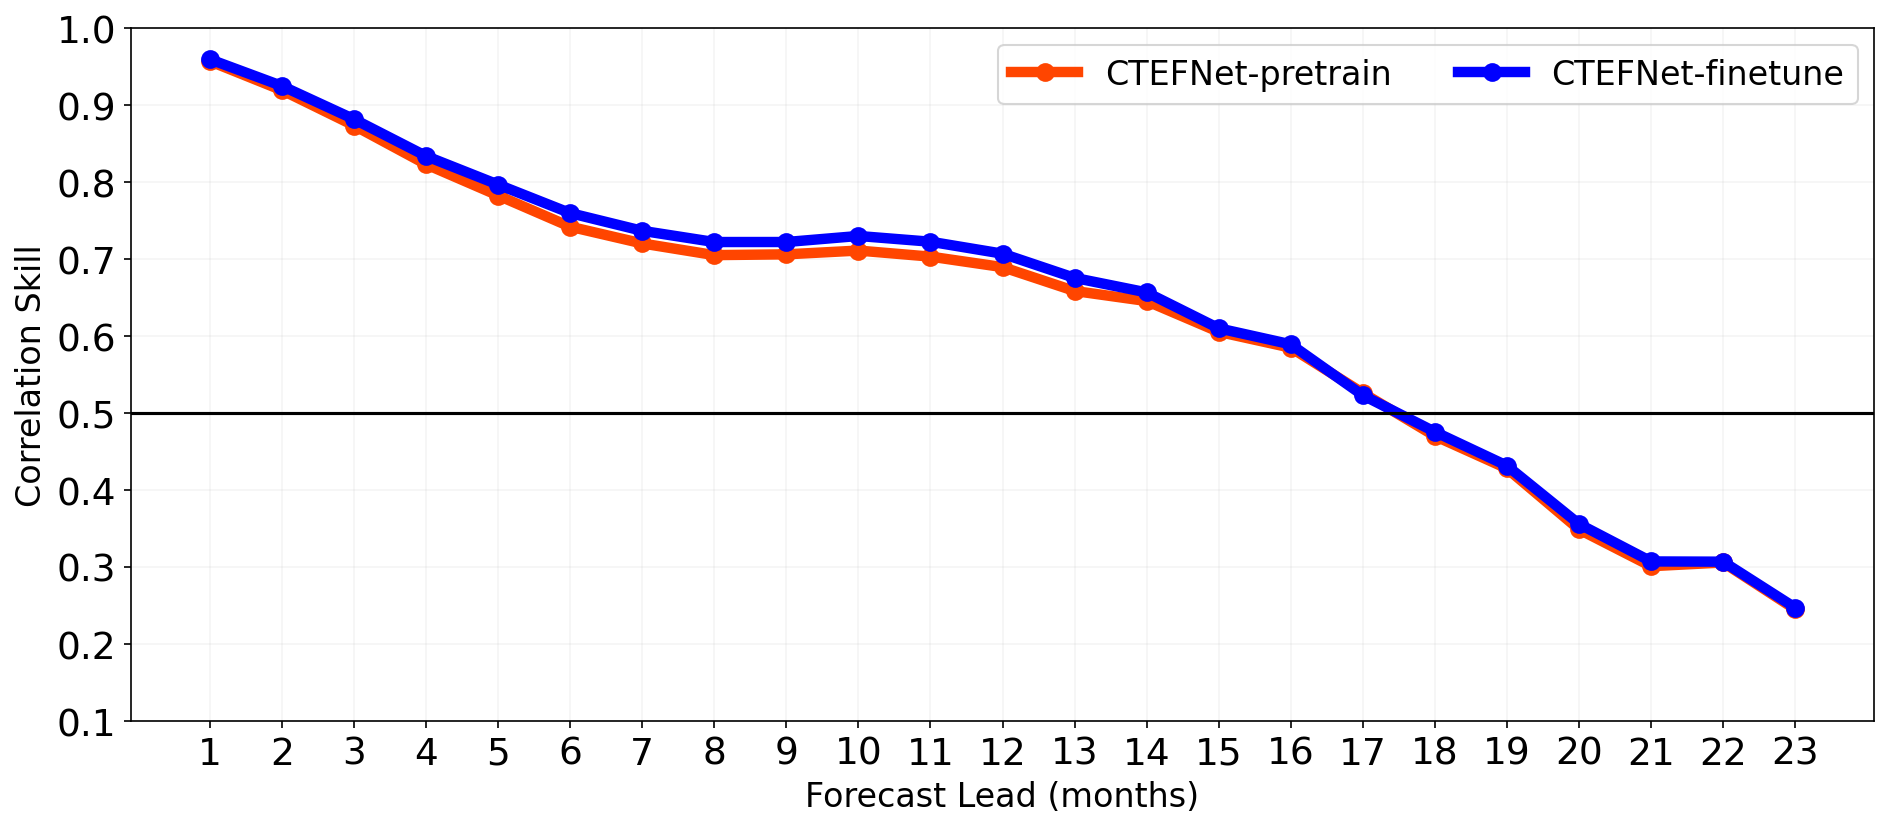

In [17]:
plot_correlation(config, corr_list)